In [6]:
import geopandas as gpd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import shapely.wkt
import shapely.geometry
import pandas as pd
import shapely.geometry.multipolygon as sh

In [7]:
## First, I try to create a bouadary of THialand for acquiring data##
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}
province = "หนองคาย"
thailandmap = thailandmap.loc[thailandmap['ADM1_TH'] == province]
print(thailandmap.unary_union.bounds)
min_lon = thailandmap.unary_union.bounds[0]
max_lon = thailandmap.unary_union.bounds[2]
max_lat = thailandmap.unary_union.bounds[1]
min_lat = thailandmap.unary_union.bounds[3]

(102.05513989400004, 17.593768951000072, 103.41287009700005, 18.305247632000032)


C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<xarray.Dataset>
Dimensions:              (lat: 256, lon: 489)
Coordinates:
  * lat                  (lat) float64 17.6 17.6 17.6 17.6 ... 18.3 18.3 18.3
  * lon                  (lon) float64 102.1 102.1 102.1 ... 103.4 103.4 103.4
Data variables:
    lccs_class           (lat, lon) uint8 ...
    processed_flag       (lat, lon) float32 ...
    current_pixel_state  (lat, lon) float32 ...
    observation_count    (lat, lon) uint16 ...
    change_count         (lat, lon) uint8 ...
    crs                  int32 ...
    lat_bounds           (lat) float64 ...
    lon_bounds           (lon) float64 ...
    time_bounds          datetime64[ns] ...
Attributes: (12/38)
    title:                      Land Cover Map of 2022
    summary:                    This dataset characterizes the land cover of ...
    type:                       C3S-LC-L4-LCCS-Map-300m-P1Y
    references:                 https://cds.climate.copernicus.eu/
    institution:                UCLouvain
    contact:              

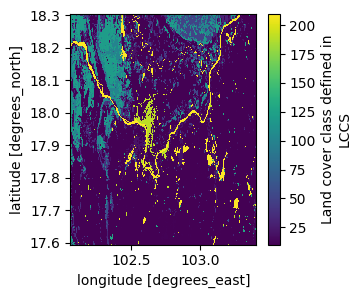

In [8]:
## Then, I acquire data according to the boundary ##
xr_landuse = xr.open_dataset("Data//dataset-satellite-land-cover//C3S-LC-L4-LCCS-Map-300m-P1Y-2022-v2.1.1.nc")
xr_landuse = xr_landuse.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
xr_landuse = xr_landuse.reindex(lat=xr_landuse.lat[::-1])
xr_landuse = xr_landuse.sel(time = '2022-01-01')
xr_landuse = xr_landuse.drop_vars('time')
xr_landuse = xr_landuse.sel(bounds = 0)
lccs_resolution = 300## meters
print(xr_landuse)
fig, ax = plt.subplots(figsize=(3,3))
xr_landuse['lccs_class'].plot(ax = ax,zorder = 0)

<xarray.Dataset>
Dimensions:    (lat: 256, lon: 489)
Coordinates:
  * lat        (lat) float64 17.6 17.6 17.6 17.6 17.61 ... 18.3 18.3 18.3 18.3
  * lon        (lon) float64 102.1 102.1 102.1 102.1 ... 103.4 103.4 103.4 103.4
Data variables:
    SI_Solar   (lat, lon) float32 ...
    SI_Wind    (lat, lon) float32 ...
    AVA_Wind   (lat, lon) float32 ...
    AVA_Solar  (lat, lon) float32 ...


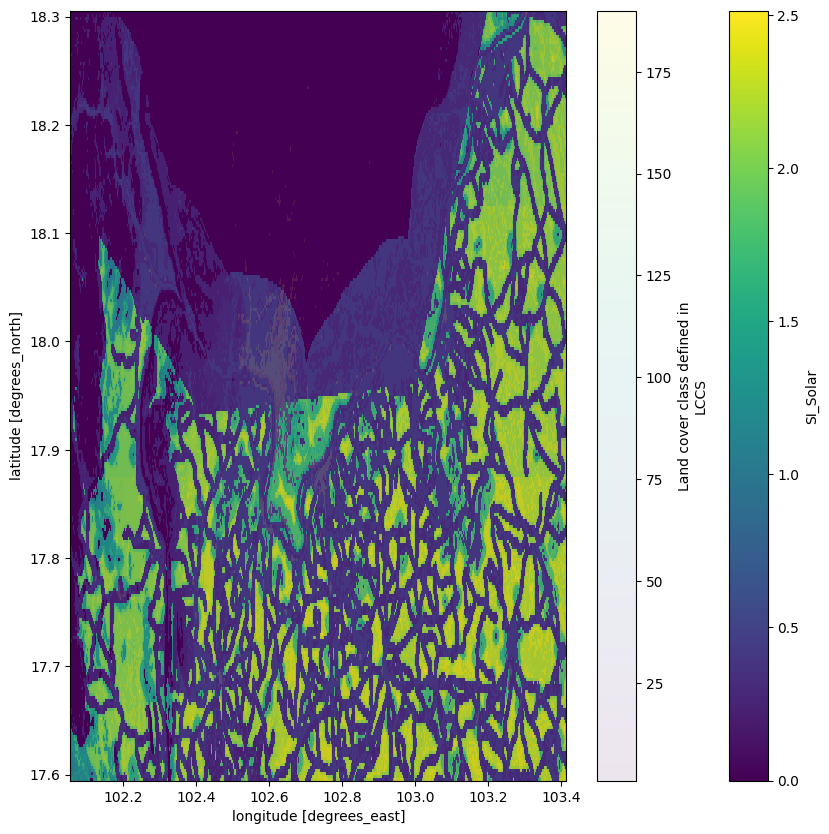

In [9]:
xr_landuse_suitability_index = xr.open_dataset('Output\\xr_final_SI.nc')
xr_landuse_suitability_index = xr_landuse_suitability_index.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon))
print(xr_landuse_suitability_index)

fig, ax = plt.subplots(figsize=(10,10))
xr_landuse_suitability_index['SI_Solar'].plot(ax = ax,zorder = 0)
xr_landuse['lccs_class'].where(xr_landuse['lccs_class']==190,1,0).plot(ax = ax,zorder = 1, alpha = 0.1)

<xarray.Dataset>
Dimensions:    (lat: 256, lon: 489)
Coordinates:
  * lat        (lat) float64 17.6 17.6 17.6 17.6 17.61 ... 18.3 18.3 18.3 18.3
  * lon        (lon) float64 102.1 102.1 102.1 102.1 ... 103.4 103.4 103.4 103.4
Data variables:
    SI_Solar   (lat, lon) float32 ...
    SI_Wind    (lat, lon) float32 ...
    AVA_Wind   (lat, lon) float32 ...
    AVA_Solar  (lat, lon) float32 ...


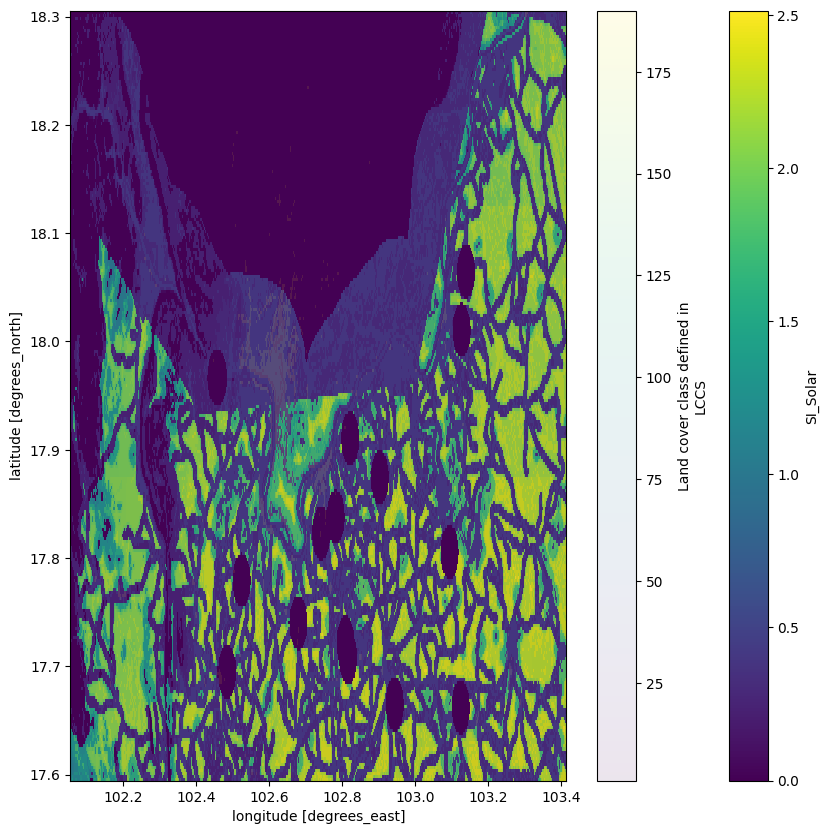

In [10]:
xr_landuse_suitability_index = xr.open_dataset('Output\\xr_final_SI_exc.nc')
xr_landuse_suitability_index = xr_landuse_suitability_index.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon))
print(xr_landuse_suitability_index)

fig, ax = plt.subplots(figsize=(10,10))
xr_landuse_suitability_index['SI_Solar'].plot(ax = ax,zorder = 0)
xr_landuse['lccs_class'].where(xr_landuse['lccs_class']==190,1,0).plot(ax = ax,zorder = 1, alpha = 0.1)